 # Laboratorio 4 - Predicción en series de tiempo

 Tiara Ramirez - Valentina Caceres

Un problema frecuente en Ingenieria es la regresion y la prediccion. Esto es, identificar el valor de una variable de interes a partir de variables
relacionadas en el caso de regression, o predecir el valor futuro que tomara una variable de interes a partir de los valores historicos de esta
misma variable. En este laboratorio realizaremos la prediccion con un horizonte de 10 pasos temporales utilizando redes LSTM (Long Short
Term Memory networks). En el codigo adjunto, el modelo de prediccion es capaz de predecir el valor futuro (10 muestras en el caso de este
ejemplo) el valor de nuestra senal de interes. En particular, aca se les entrega el codigo en python + Torch para realizar la prediccion de una
senal sinusoide sintetizada. Para esta sesion se les pide 

1.- Realizar la prediccion para un horizonte de 10 muestras (correr el codigo, en esta notebook, o en sus computadores). Que funcional se debe
minimizar para este problema de prediccion? Reportar el error de entrenamiento en cada iteracion.

2.- Cual es el desempeno al agregar ruido ( media 0, std=0.1; std=0,5) a la sinusoide?

3.- Al agregar ruido m=0, std=0.2. Empeora el desempeno si extendemos el horizonte de prediccion?

4.- Elegir serie de tiempo multidimensional y hacer una compocicion o hacer estimacion y prediccion de uno de los canales a partir de la informacion de los otros canales.

Epoch [10/100], Loss: 0.0180
Epoch [20/100], Loss: 0.0131
Epoch [30/100], Loss: 0.0121
Epoch [40/100], Loss: 0.0103
Epoch [50/100], Loss: 0.0115
Epoch [60/100], Loss: 0.0089
Epoch [70/100], Loss: 0.0101
Epoch [80/100], Loss: 0.0093
Epoch [90/100], Loss: 0.0090
Epoch [100/100], Loss: 0.0109


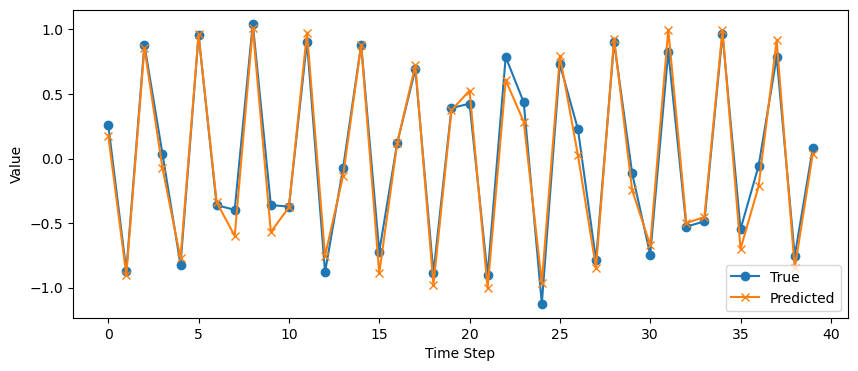

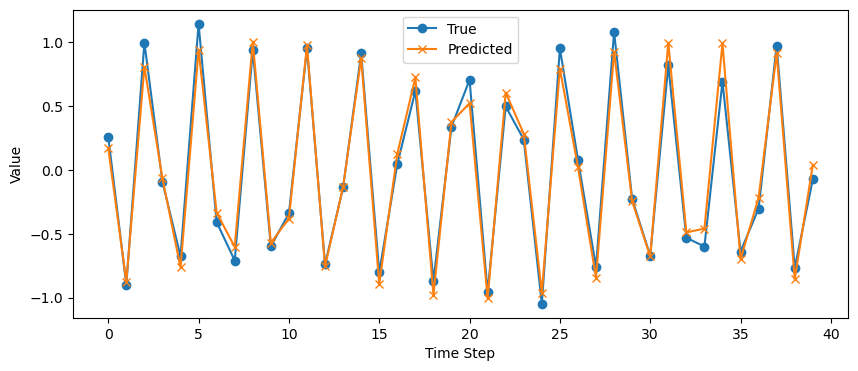

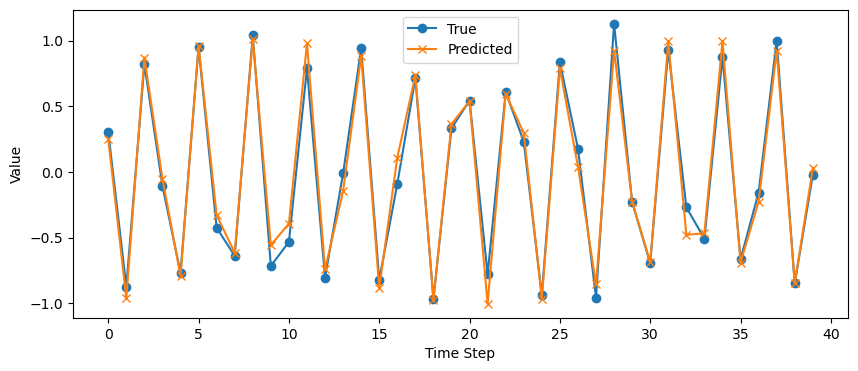

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

# Creamos una serie de tiempo sintetica (e.g., onda sinusoidal)
horizonte = 10        # horizonte de prediccion
f = 36                # frecuencia de la onda
varianza = 0.1        # varianza del ruido

# Funcion para generar una onda sinusoidal con ruido
def generate_sine_wave(seq_length, horizonte,  varianza, num_samples,):
    X = []
    y = []
    for i in range(num_samples):
        start = np.random.randint(0, 40)                                                            # inicio de la serie de tiempo
        time_steps = np.linspace(start, start + 10, seq_length)                                     # secuencia de tiempo
        data = np.sin(2 * np.pi * f * time_steps) + np.random.normal(0, varianza, seq_length)       # onda sinusoidal + ruido
        X.append(data[:-horizonte])                                                                 # secuencia de tiempo de entrada
        y.append(data[horizonte:])                                                                  # secuencia de tiempo de salida
    return np.array(X), np.array(y)                                                                 # convertir a numpy arrays

# Dataset personalizado para cargar los datos
class SineWaveDataset(Dataset):
    # Inicializa el dataset
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)   # convertir a tensor
        self.y = torch.tensor(y, dtype=torch.float32)   # convertir a tensor
        
    # Retorna el numero de muestras
    def __len__(self):
        return len(self.X)  
    
    # Retorna una muestra en la posicion idx
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Hyperparameters
seq_length = 50         # longitud de la secuencia
hidden_size = 20        # tamaño de la capa oculta
input_size = 1          # tamaño de la entrada
output_size = 1         # tamaño de la salida
num_layers = 2          # numero de capas
num_epochs = 100        # numero de epocas
batch_size = 16         # tamaño del lote
learning_rate = 0.001   # tasa de aprendizaje

# Cargar los datos
X, y = generate_sine_wave(seq_length, horizonte ,varianza, num_samples=500) # Generar datos
train_data = SineWaveDataset(X, y)                                          # Crear dataset
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)  # Crear dataloader

# Definir el modelo LSTM
class LSTMModel(nn.Module):
    # Inicializa el modelo
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()                                                   # Inicializa la clase base
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)          # LSTM layer
        self.fc = nn.Linear(hidden_size, output_size)                                       # Fully connected layer           
    
    # Forward pass
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)                   # Inicializa hidden state
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)                   # Inicializa cell state
        out, _ = self.lstm(x, (h0, c0))                                                     # Forward pass through LSTM layer                
        out = self.fc(out)                                                                  # Forward pass through Fully connected layer
        return out

# Inicializa el modelo, funcion objetivo y optimizador
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)   # Inicializa el modelo
criterion = nn.MSELoss()                                                                                            # Funcion objetivo                   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)                                                  # Optimizador

# Entrenamiento del modelo
model.train()
for epoch in range(num_epochs):
    for batch_idx, (inputs, targets) in enumerate(train_loader):         # Iterar sobre los datos
        inputs = inputs.unsqueeze(-1)                                    # Add input dimension (batch_size, seq_length, input_size)
        targets = targets.unsqueeze(-1)                                  # Add target dimension

        # Forward pass
        outputs = model(inputs)                                          # Forward pass                              
        loss = criterion(outputs, targets)                               # Calcular la perdida    
    
        # Backward and optimize
        optimizer.zero_grad()                                            # Inicializar los gradientes      
        loss.backward()                                                  # Backward pass
        optimizer.step()                                                 # Optimizar    

    # Imprimir la perdida cada 10 epocas
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Generate test data
test_X, test_y = generate_sine_wave(seq_length, horizonte,varianza, num_samples=10)
test_data = SineWaveDataset(test_X, test_y)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

#Switch to evaluation mode
model.eval()
predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.unsqueeze(-1) # Add input dimension (1, seq_length, input_size)
        outputs = model(inputs)
        predictions.append(outputs.squeeze().numpy())

# Plot predictions vs true values
for i in range(3): # Plotting only 3 samples for visualization
    plt.figure(figsize=(10, 4))
    plt.plot(range(seq_length-horizonte), test_y[i], label="True", marker='o')
    plt.plot(range(seq_length-horizonte), predictions[i], label="Predicted", marker='x')
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()